# AMSC698K Homework 11
##### Elijah Kin

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex

### Problem A
Notebook `QHED_intro.ipynb` introduces a quantum algorithm to extract color boundaries (edges) in images. The 512x512-pixel gray-tone picture at the end (`qhed_image.jpg`) features strong contours, which are easy to identify.

1. Identify the edges in this picture using a classical and a quantum technique. If your laptop doesn't enough RAM, you might need to divide the image into 4 sub-images, analyze each of them, and add the results to yield the edge image.

In [2]:
## define Decrement Gate (amplitude permutation gate)
def Dgate(nqubits):
    circ = QuantumCircuit(nqubits)
    for k in reversed(range(1,nqubits)):
        ctrl = "0"*k
        circ.mcx(list(range(k)), k, ctrl_state=ctrl)
    circ.x(0)
    return circ

def Dmatrix(nqubits):
    return Operator(Dgate(nqubits)).data

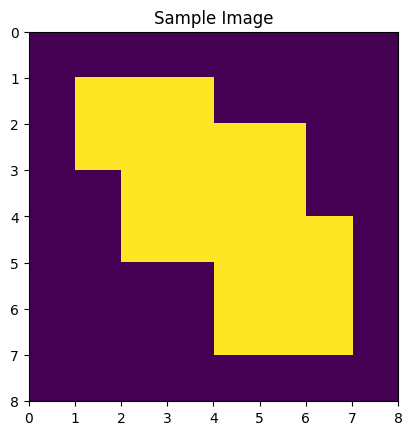

In [3]:
## 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 1, 1, 1, 0],
                  [0, 0, 0, 0, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Function for plotting the image using matplotlib
def plot_image(img, title=None, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, **kwargs)
    ax.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    ticks_cnt = img.shape[0]//8 if img.shape[0] > 8 else 1
    ax.set_xticks(range(0,img.shape[0]+1, ticks_cnt))
    ax.set_yticks(range(0,img.shape[1]+1, ticks_cnt))
    if title is not None:
        ax.set_title(title)

plot_image(image, 'Sample Image')

In [4]:
## convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # calculate the RMS value
    rms = np.sqrt(np.sum(img_data.flatten()**2))

    # return flattened normalized image
    return img_data.flatten() / rms

# get amplitude ancoded pixel values
#  (a) horizontal
image_norm_h = amplitude_encode(image)

#   (b) vertical
image_norm_v = amplitude_encode(image.T)

Image size: (8, 8)  -> number of qubits: 6


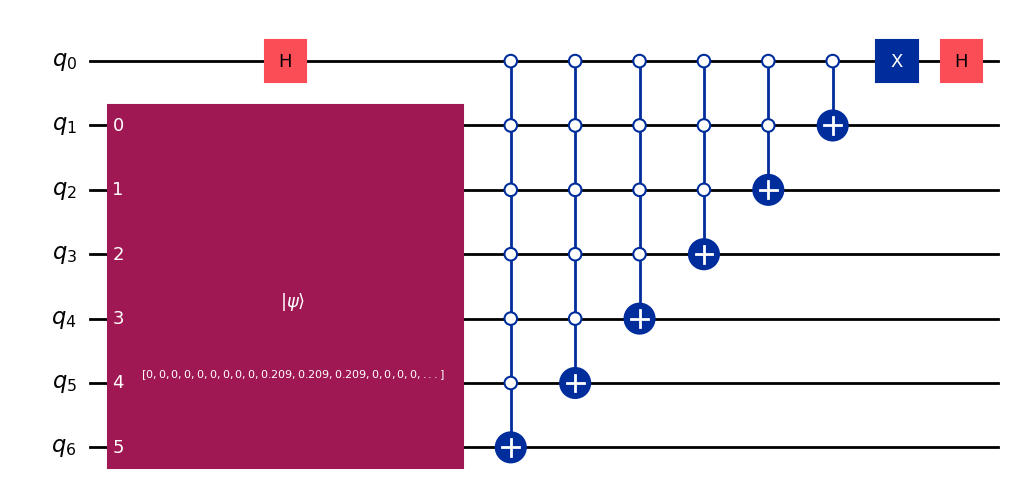

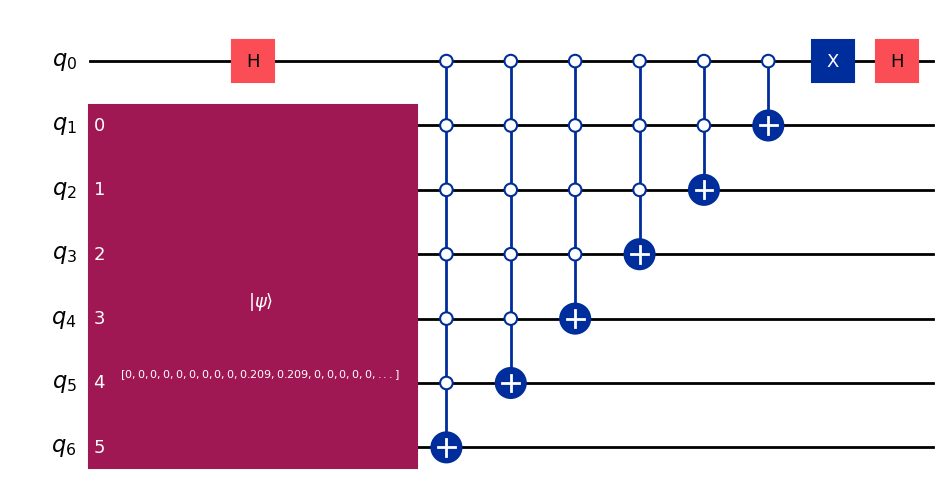

In [5]:
## number of qubits
nq_image = int(np.ceil(np.log2(image.size)))
qr = QuantumRegister(nq_image+1, name="q")
q_aux = qr[0]
print("Image size:", image.shape," -> number of qubits:",nq_image)

## create the circuit for horizontal scan
qc_h = QuantumCircuit(qr)
qc_h.initialize(image_norm_h, qr[1:])
qc_h.h(q_aux)
qc_h.compose(Dgate(nq_image+1), qr, inplace=True)
qc_h.h(q_aux)
display(qc_h.draw('mpl'))
qc_h.save_statevector()
qc_h.measure_all()

# create the circuit for vertical scan
qc_v = QuantumCircuit(qr)
qc_v.initialize(image_norm_v, qr[1:])
qc_v.h(q_aux)
qc_v.compose(Dgate(nq_image+1), qr, inplace=True)
qc_v.h(q_aux)
display(qc_v.draw('mpl'))
qc_v.save_statevector()
qc_v.measure_all()

circ_list = [qc_h, qc_v]

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

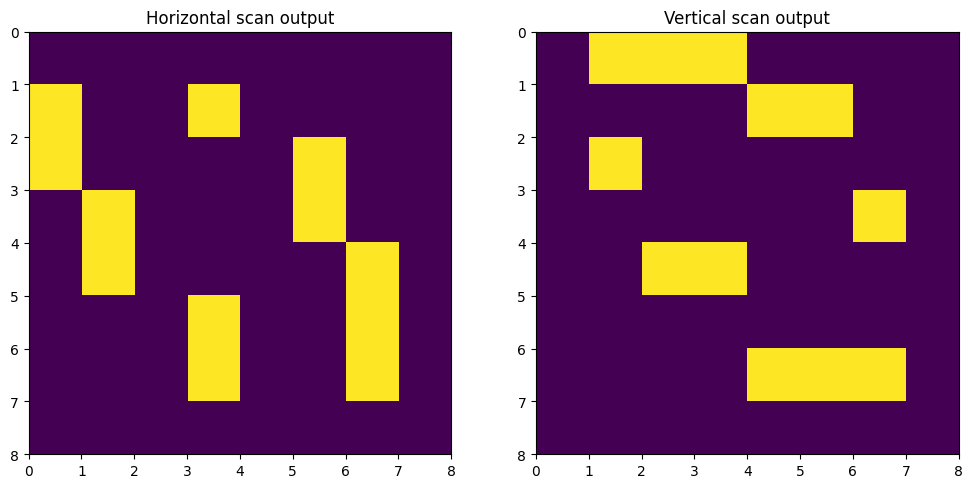

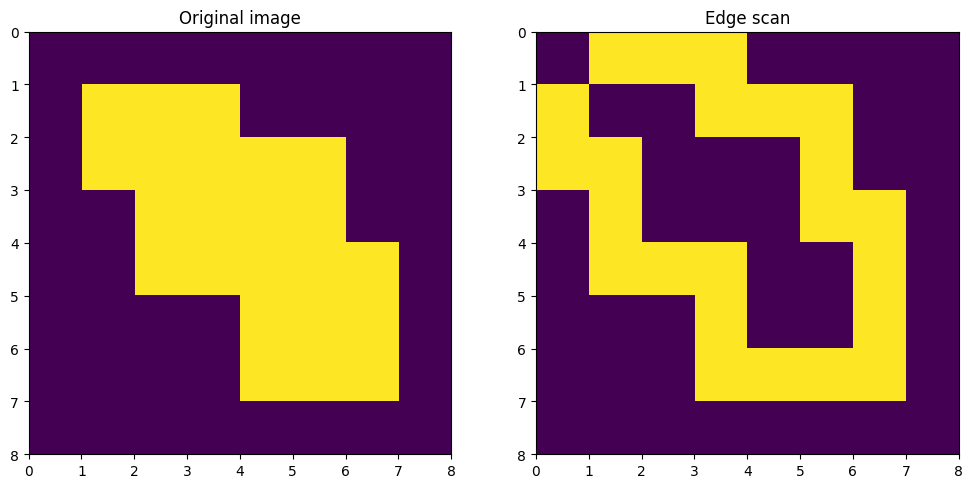

In [6]:
## Simulating the cirucits
## (a) statevector simulator
backend = Aer.get_backend('aer_simulator')
results = backend.run(circ_list).result()
statevec_h = results.get_statevector(qc_h)
statevec_v = results.get_statevector(qc_v)

print('Horizontal scan statevector:')
display(array_to_latex(statevec_h, max_size=60))
print('\nVertical scan statevector:')
display(array_to_latex(statevec_v, max_size=60))

# select odd states from the raw statevector and reshape to 8x8 matrix
ampl_h_odd = np.array([ statevec_h[2*i+1].real for i in range(2**nq_image) ]).reshape(image.shape)
ampl_v_odd = np.array([ statevec_v[2*i+1].real for i in range(2**nq_image) ]).reshape(image.shape).T
# convert to binary values for plots
edge_scan_h = np.where(np.abs(ampl_h_odd)>1e-9, 1, 0)
edge_scan_v = np.where(np.abs(ampl_v_odd)>1e-9, 1, 0)

# Plotting the Horizontal and vertical scans
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_image(edge_scan_h, 'Horizontal scan output', ax=ax[0])
plot_image(edge_scan_v, 'Vertical scan output', ax=ax[1])
plt.show()
fig, ax = plt.subplots(1,2, figsize=(12,6))
edge_scan = edge_scan_h | edge_scan_v
plot_image(image, "Original image", ax=ax[0])
plot_image(edge_scan, "Edge scan", ax=ax[1])

2. Run your quantum circuit on "ionq_simulator" with noise-model "forte-1", adjust thresholds (tolerances) if necessary, and submit the code to "ionq_qpu.forte-1".

In [7]:
# TODO

### Problem B
1. Notebook `FER_intro.ipynb` contains a simple code to perform an analysis of facial expressions. The routine "faces_classifier" simply compares a test image with one random example of the "happy face" subset and one of the "sad face" subset. Find more reliable ways to classify a random test image. (You may modify the quantum circuit if desired.)

In [8]:
# TODO

2. Explain how the quantum circuit (pictured in `FER_intro.ipynb`) performs the classification starting from the state $|0\rangle_{aux} |0\rangle_{index} |00\dots0\rangle_{data} |0\rangle_{class}$.

TODO

3. (extra credit) Instead of using the small subset of "happy" and "sad" faces presented in class (file: ffhq_subset.zip Download ffhq_subset.zip) find a way to classify reliably the larger set of FFHQ images and landmark points in Files -> Course Material -> Homework.

In [9]:
# TODO